In [1]:
import easyocr
import torch
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.text import CharErrorRate
import cv2
import pandas as pd
import seaborn as sns

%matplotlib inline

is_cuda = torch.cuda.is_available()

# init reader object
reader = easyocr.Reader(['en'], gpu=is_cuda, verbose=False)

In [2]:
import json

with open('/home/nattkorat/Desktop/klpr_dataset/annotations/instances_default.json', 'r') as file:
    data = json.load(file)

data.keys()

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])

In [3]:
len(data['images'])

3010

In [4]:
data['categories']

[{'id': 1, 'name': 'vehicle', 'supercategory': ''},
 {'id': 2, 'name': 'plate', 'supercategory': ''},
 {'id': 3, 'name': 'serial', 'supercategory': ''},
 {'id': 4, 'name': 'place', 'supercategory': ''}]

In [7]:
len(data['annotations'])

28357

In [107]:
ann_d = data['annotations'][0]
ann_d

{'id': 1,
 'image_id': 1,
 'category_id': 3,
 'segmentation': [],
 'area': 2677.351499999996,
 'bbox': [796.1, 650.35, 78.63, 34.05],
 'iscrowd': 0,
 'attributes': {'vehicle_id': 0.0,
  'label': '3A-0321',
  'occluded': False,
  'rotation': 0.0}}

In [108]:
id = [ i['category_id'] for i in data['annotations']]

uid = set(id)
cat = {}
for s in uid:
    cat[s] = 0

for i in id:
    cat[i] += 1

cat

{1: 13174, 2: 6594, 3: 4391, 4: 4198}

In [8]:
place = [d for d in data['annotations'] if d['category_id'] == 4]
place[:2]

[{'id': 4,
  'image_id': 1,
  'category_id': 4,
  'segmentation': [],
  'area': 1494.4330000000016,
  'bbox': [805.9, 628.4, 62.95, 23.74],
  'iscrowd': 0,
  'attributes': {'label': 'Modulkiri',
   'vehicle_id': 0.0,
   'occluded': False,
   'rotation': 0.0}},
 {'id': 8,
  'image_id': 2,
  'category_id': 4,
  'segmentation': [],
  'area': 1169.8802999999955,
  'bbox': [379.79, 904.85, 58.29, 20.07],
  'iscrowd': 0,
  'attributes': {'label': 'Kampong Cham',
   'vehicle_id': 0.0,
   'occluded': False,
   'rotation': 0.0}}]

In [110]:
province  = []
for d in place:
    province.append(d['attributes']['label'])

province

unp = set(province)
unp

pro_dic = {}

for un in unp:
    pro_dic[un] = 0

pro_dic

for pro in province:
    pro_dic[pro] += 1

pro_dic

{'Pailin': 5,
 'Prey Veng': 92,
 'Siem Reap': 223,
 'Oudar Meanchey': 18,
 'Preah Sihanouk': 30,
 'Kampong Chhnang': 32,
 'Svay Rieng': 134,
 'Kampong Speu': 64,
 'Takeo': 123,
 'Preah Vihear': 69,
 'State': 208,
 'Pursat': 5,
 'Kep': 124,
 'RCAF': 34,
 'Phnom Penh': 1422,
 'Banteay Meanchey': 22,
 'Tboung Khmum': 129,
 'Kampong Thom': 162,
 'Battambang': 119,
 'Ratanakiri': 39,
 'Cambodia': 243,
 'Modulkiri': 22,
 'Kratie': 14,
 'Koh Kong': 10,
 'Kandal': 546,
 'Kampot': 105,
 'Kampong Cham': 149,
 'Police': 55}

<BarContainer object of 28 artists>

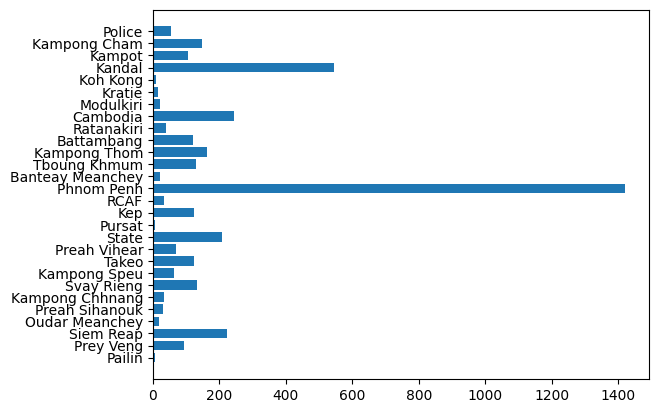

In [111]:
import pandas as pd
from matplotlib import pyplot as plt

place_label = {'province': [], 'value' : []}

for key, val in pro_dic.items():
    place_label['province'].append(key)
    place_label['value'].append(val)

df = pd.DataFrame(place_label)

plt.barh(df.province, df.value)

## Preparing Data for Training

{'id': 2, 'name': 'plate', 'supercategory': ''},
{'id': 3, 'name': 'serial', 'supercategory': ''},

We need these two to train for the first step to recognize license plate.

We can set the id for the plate to 0 and serial to 1. and bounding which will normalize to the YOLO style for object detection task.

In [9]:
plate_serial = []

for dat in data['annotations']:
    if dat['category_id'] in [2, 3]:
        plate_serial.append(dat)

plate_serial[:2]

[{'id': 1,
  'image_id': 1,
  'category_id': 3,
  'segmentation': [],
  'area': 2677.351499999996,
  'bbox': [796.1, 650.35, 78.63, 34.05],
  'iscrowd': 0,
  'attributes': {'vehicle_id': 0.0,
   'label': '3A-0321',
   'occluded': False,
   'rotation': 0.0}},
 {'id': 3,
  'image_id': 1,
  'category_id': 2,
  'segmentation': [],
  'area': 6435.97899999999,
  'bbox': [788.38, 626.33, 92.14, 69.85],
  'iscrowd': 0,
  'attributes': {'vehicle_id': 0.0, 'occluded': False, 'rotation': 0.0}}]

### Getting bbox and Label of all serial from plate number

I want to get just the information from the serial to perform on the OCR Phase. And images are not at hight quality.

    {
        "image_id":
        "bbox":
        ["attributes"]["label"]
        ["attributes"]["vehicle_id"]
    }

In [10]:
serial_info = []
for d in plate_serial:
    if d['category_id'] == 3:
        serial = {
            "image_id": d['image_id'],
            "bbox": d['bbox'],
            "label": d['attributes']['label'],
            "place": [i['attributes']['label'] for i in place if i['attributes']['vehicle_id'] == d['attributes']['vehicle_id']][0],
            "file_name": [i['file_name'] for i in data['images'] if i['id'] == d['image_id']][0] # get file name from images data
        }
        serial_info.append(serial)

serial_info[:5]

[{'image_id': 1,
  'bbox': [796.1, 650.35, 78.63, 34.05],
  'label': '3A-0321',
  'place': 'Modulkiri',
  'file_name': '--484132167868878048907440-c.jpg'},
 {'image_id': 2,
  'bbox': [357.39, 921.86, 102.72, 37.26],
  'label': '2A-7176',
  'place': 'Modulkiri',
  'file_name': '-2000-8500-0977857183-781288167987857290124015-c_jpg.rf.fb35c072d7bf5cf2d50b433b477b6f77.jpg'},
 {'image_id': 3,
  'bbox': [412.66, 887.34, 82.1, 28.65],
  'label': '3A-0779',
  'place': 'Modulkiri',
  'file_name': '-872300167906305244721876-e_jpg.rf.965aaf5f9848b506ea980b911e6fee48.jpg'},
 {'image_id': 4,
  'bbox': [540.92, 710.6, 166.91, 48.5],
  'label': '2A-1320',
  'place': 'Modulkiri',
  'file_name': '-96-613864167962126619007504-c_jpg.rf.b6c2f221653f9769ca415df0f132cb68.jpg'},
 {'image_id': 5,
  'bbox': [209.81, 669.03, 110.6, 38.16],
  'label': '2B-5400',
  'place': 'Modulkiri',
  'file_name': '-crv98--314623167542570845124864-b.jpg'}]

In [11]:
def pre_process(img):
    # Stretch the image to have a width of 640 and maintain the aspect ratio
    desired_width = 640
    aspect_ratio = img.shape[1] / img.shape[0]
    desired_height = int(desired_width / aspect_ratio)

    # Resize the image
    resized_img = cv2.resize(img, (desired_width, desired_height), interpolation=cv2.INTER_LINEAR)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Apply Otsu's thresholding
    _, thresholded_image = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # add sharpen filter
    sharpen_filter = np.array(
        [
            [-1,-1,-1],
            [-1, 9, -1],
            [-1,-1,-1]
        ]
    )

    sh_img = cv2.filter2D(thresholded_image, -1, sharpen_filter)

    return sh_img

In [12]:
test = serial_info[1]

test

{'image_id': 2,
 'bbox': [357.39, 921.86, 102.72, 37.26],
 'label': '2A-7176',
 'place': 'Modulkiri',
 'file_name': '-2000-8500-0977857183-781288167987857290124015-c_jpg.rf.fb35c072d7bf5cf2d50b433b477b6f77.jpg'}

In [15]:
import cv2

for i in range(len(serial_info)):
    bbox = serial_info[i]['bbox']

    # convert bbox to int type
    x, y, w, h = map(int, bbox) 
    x2, y2 = x + w, y + h

    img = '/home/nattkorat/Desktop/klpr_dataset/images/'+serial_info[i]['file_name']
    
    image = cv2.imread(img) # read image from dataset

    preprocess = pre_process(image[y:y2, x:x2])

    text = reader.readtext(preprocess)
    result = [i[-2] for i in text]
    txt = ''.join(result)

    serial_info[i]['prediction'] = txt.upper()

serial_info[:5]

[{'image_id': 1,
  'bbox': [796.1, 650.35, 78.63, 34.05],
  'label': '3A-0321',
  'place': 'Modulkiri',
  'file_name': '--484132167868878048907440-c.jpg',
  'prediction': '3A-0321'},
 {'image_id': 2,
  'bbox': [357.39, 921.86, 102.72, 37.26],
  'label': '2A-7176',
  'place': 'Modulkiri',
  'file_name': '-2000-8500-0977857183-781288167987857290124015-c_jpg.rf.fb35c072d7bf5cf2d50b433b477b6f77.jpg',
  'prediction': '2A-7176'},
 {'image_id': 3,
  'bbox': [412.66, 887.34, 82.1, 28.65],
  'label': '3A-0779',
  'place': 'Modulkiri',
  'file_name': '-872300167906305244721876-e_jpg.rf.965aaf5f9848b506ea980b911e6fee48.jpg',
  'prediction': '34-0779'},
 {'image_id': 4,
  'bbox': [540.92, 710.6, 166.91, 48.5],
  'label': '2A-1320',
  'place': 'Modulkiri',
  'file_name': '-96-613864167962126619007504-c_jpg.rf.b6c2f221653f9769ca415df0f132cb68.jpg',
  'prediction': '2A-1320'},
 {'image_id': 5,
  'bbox': [209.81, 669.03, 110.6, 38.16],
  'label': '2B-5400',
  'place': 'Modulkiri',
  'file_name': '-crv

In [16]:
df = {} # create an empty dictionary
for key in serial_info[0]. keys():
    df[key] = []

for serial in serial_info:
    for k in serial_info[0].keys():
        df[k].append(serial[k])

df = pd.DataFrame(df)
# df.to_csv('OCR_evaluation.csv', index=False)
df.head()

,image_id,bbox,label,place,file_name,prediction
0,1,"[796.1, 650.35, 78.63, 34.05]",3A-0321,Modulkiri,--484132167868878048907440-c.jpg,3A-0321
1,2,"[357.39, 921.86, 102.72, 37.26]",2A-7176,Modulkiri,-2000-8500-0977857183-781288167987857290124015...,2A-7176
2,3,"[412.66, 887.34, 82.1, 28.65]",3A-0779,Modulkiri,-872300167906305244721876-e_jpg.rf.965aaf5f984...,34-0779
3,4,"[540.92, 710.6, 166.91, 48.5]",2A-1320,Modulkiri,-96-613864167962126619007504-c_jpg.rf.b6c2f221...,2A-1320
4,5,"[209.81, 669.03, 110.6, 38.16]",2B-5400,Modulkiri,-crv98--314623167542570845124864-b.jpg,2B-5400


In [17]:
import re

# removing spaces and other special characters
def remove_space_special_chars(string):
    result = re.sub(r'[^a-zA-Z0-9]', '', string)
    return result


# replace character (B - 8) (0 - O) (I - 1) (A - 4)
# first character must be number the most number is
def num_to_char(char):
    if char == '1':
        return 'i'
    if char == '0':
        return 'o'
    if char == '4':
        return 'a'
    if char == '8':
        return 'b'
    return char

def char_to_num(char):
    if char == 'i':
        return '1'
    if char == 'o':
        return '0'
    if char == 'a':
        return '4'
    if char == 'b':
        return '8'
    return char


def char_map(txt, label = ''):
    string = list(remove_space_special_chars(txt.lower()))
    # print(string)
    length = len(string)

    if label in ['Police', 'State', 'RCAF']:
        for i in range(length):
            string[i] = char_to_num(string[i])
            # print(string[i])
        string.insert(1, '-')
        
    elif label == 'Cambodia':
        string = list(txt)
        for i in range(len(string)):
            if string[i] in ['_', ',', '*']:
                string[i] = '.'
            if string[i] == ' ':
                string[i] = ''

    else:
        if length > 0:
            first = string[0]
            # replace char with num
            if not first.isdigit():
                string[0] = char_to_num(first)

            if length >= 2:
                second = string[1] # the second character must be str
                if second.isdigit():
                    string[1] = num_to_char(second)
                    
            if length >= 3:
                third = string[2] # has two case if len > 6 is letter else number
                if length > 6:
                    string[2] = num_to_char(third)
                else:
                    string[2] = char_to_num(third)
            
            # for other must be number
            for i in range(3, length):
                string[i] = char_to_num(string[i])

        if length == 7:
            string.insert(3, '-')
        
        if length == 6:
            string.insert(2, '-')


    
    string = ''.join(string).upper()
    return string

if __name__ == '__main__':
    print(char_map('2Ib.661', 'Siem Reap'))

2I-8661


In [18]:
# df.loc[True, 'label_clean'] = True
len(df)
clean = []
for i in range(len(df)):
    txt = char_map(df['label'][i], df['place'][i])
    clean.append(txt)

clean_predict = []
for i in range(len(df)):
    txt = char_map(df['prediction'][i], df['place'][i])
    clean_predict.append(txt)

df['post_process_predict'] = clean_predict

df.head()

,image_id,bbox,label,place,file_name,prediction,post_process_predict
0,1,"[796.1, 650.35, 78.63, 34.05]",3A-0321,Modulkiri,--484132167868878048907440-c.jpg,3A-0321,3A-0321
1,2,"[357.39, 921.86, 102.72, 37.26]",2A-7176,Modulkiri,-2000-8500-0977857183-781288167987857290124015...,2A-7176,2A-7176
2,3,"[412.66, 887.34, 82.1, 28.65]",3A-0779,Modulkiri,-872300167906305244721876-e_jpg.rf.965aaf5f984...,34-0779,3A-0779
3,4,"[540.92, 710.6, 166.91, 48.5]",2A-1320,Modulkiri,-96-613864167962126619007504-c_jpg.rf.b6c2f221...,2A-1320,2A-1320
4,5,"[209.81, 669.03, 110.6, 38.16]",2B-5400,Modulkiri,-crv98--314623167542570845124864-b.jpg,2B-5400,2B-5400


In [19]:
cer = CharErrorRate()

err = cer(df['label'], df['prediction'])
err

tensor(0.3961)

In [20]:
err = cer(df['label'], df['post_process_predict'])
err

tensor(0.3098)

In [21]:
bbox = df['bbox']

width = [i[-2] for i in bbox]
height = [i[-1] for i in bbox]

df['width'] = width
df['height'] = height
df.head()

,image_id,bbox,label,place,file_name,prediction,post_process_predict,width,height
0,1,"[796.1, 650.35, 78.63, 34.05]",3A-0321,Modulkiri,--484132167868878048907440-c.jpg,3A-0321,3A-0321,78.63,34.05
1,2,"[357.39, 921.86, 102.72, 37.26]",2A-7176,Modulkiri,-2000-8500-0977857183-781288167987857290124015...,2A-7176,2A-7176,102.72,37.26
2,3,"[412.66, 887.34, 82.1, 28.65]",3A-0779,Modulkiri,-872300167906305244721876-e_jpg.rf.965aaf5f984...,34-0779,3A-0779,82.10,28.65
3,4,"[540.92, 710.6, 166.91, 48.5]",2A-1320,Modulkiri,-96-613864167962126619007504-c_jpg.rf.b6c2f221...,2A-1320,2A-1320,166.91,48.50
4,5,"[209.81, 669.03, 110.6, 38.16]",2B-5400,Modulkiri,-crv98--314623167542570845124864-b.jpg,2B-5400,2B-5400,110.60,38.16


In [22]:
rate = [cer(df['label'][i], df['post_process_predict'][i]).item() for i in range(len(df))]
df['CER'] = rate
df.head()

,image_id,bbox,label,place,file_name,prediction,post_process_predict,width,height,CER
0,1,"[796.1, 650.35, 78.63, 34.05]",3A-0321,Modulkiri,--484132167868878048907440-c.jpg,3A-0321,3A-0321,78.63,34.05,0.0
1,2,"[357.39, 921.86, 102.72, 37.26]",2A-7176,Modulkiri,-2000-8500-0977857183-781288167987857290124015...,2A-7176,2A-7176,102.72,37.26,0.0
2,3,"[412.66, 887.34, 82.1, 28.65]",3A-0779,Modulkiri,-872300167906305244721876-e_jpg.rf.965aaf5f984...,34-0779,3A-0779,82.10,28.65,0.0
3,4,"[540.92, 710.6, 166.91, 48.5]",2A-1320,Modulkiri,-96-613864167962126619007504-c_jpg.rf.b6c2f221...,2A-1320,2A-1320,166.91,48.50,0.0
4,5,"[209.81, 669.03, 110.6, 38.16]",2B-5400,Modulkiri,-crv98--314623167542570845124864-b.jpg,2B-5400,2B-5400,110.60,38.16,0.0


### Correlationship between width, height, and CER

In [23]:
corr_matrics = df[['width', 'height', 'CER']].corr()
corr_matrics

,width,height,CER
width,1.000000,0.891496,-0.214274
height,0.891496,1.000000,-0.163393
CER,-0.214274,-0.163393,1.000000


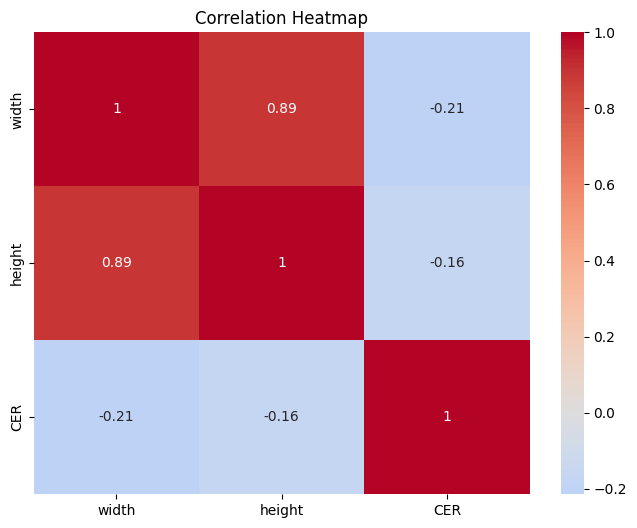

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrics, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation Heatmap')
plt.show()

In [25]:
df.to_csv('OCR_evaluation.csv', index=False)

### Checking for width and heigh distribution

In [26]:
df = pd.read_csv('OCR_evaluation.csv')
df.head()

,image_id,bbox,label,place,file_name,prediction,post_process_predict,width,height,CER
0,1,"[796.1, 650.35, 78.63, 34.05]",3A-0321,Modulkiri,--484132167868878048907440-c.jpg,3A-0321,3A-0321,78.63,34.05,0.0
1,2,"[357.39, 921.86, 102.72, 37.26]",2A-7176,Modulkiri,-2000-8500-0977857183-781288167987857290124015...,2A-7176,2A-7176,102.72,37.26,0.0
2,3,"[412.66, 887.34, 82.1, 28.65]",3A-0779,Modulkiri,-872300167906305244721876-e_jpg.rf.965aaf5f984...,34-0779,3A-0779,82.10,28.65,0.0
3,4,"[540.92, 710.6, 166.91, 48.5]",2A-1320,Modulkiri,-96-613864167962126619007504-c_jpg.rf.b6c2f221...,2A-1320,2A-1320,166.91,48.50,0.0
4,5,"[209.81, 669.03, 110.6, 38.16]",2B-5400,Modulkiri,-crv98--314623167542570845124864-b.jpg,2B-5400,2B-5400,110.60,38.16,0.0
